# Работа с текстом: мешок слов, tf-idf, предобработка текста.

... или зачем нужна предобработка. Источник: Высшая школа экономики.
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/10_Aehfbxgr3fxXPgI1gM5BTU8yOy-Z4U)

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Классификацию по тональности используют в рекомендательных системах, чтобы понять, понравилось ли людям кафе, кино, etc.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [ ]:
# если у вас линукс / мак / collab или ещё какая-то среда, в которой работает wget, можно так:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2025-03-11 12:38:52--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/6mg7rw3wltux83q2o4ah4/positive.csv?rlkey=cvruhzofza9kkfxwzyp2vskfd [following]
--2025-03-11 12:38:52--  https://www.dropbox.com/scl/fi/6mg7rw3wltux83q2o4ah4/positive.csv?rlkey=cvruhzofza9kkfxwzyp2vskfd
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2bbe31e0fd614db1fadb619b81.dl.dropboxusercontent.com/cd/0/inline/Clo0mVzWqhHGX4Y8GogeY6F4M6ro2Ls3dT9oStUK6gGzO4JpAetKfS4_KSJzGxrlae3DNCpr0Wtehiap1xDcEPTQGYwLwBwDVO4TK3OmVR3FnT2yx6XZzL7Z8xcdFTxCrBQ/file# [following]
--2025-03-11 12:38:53--  https://uc2bbe31e0fd614db1fadb619b81.dl.dropboxusercontent.com/cd/0/inline/Clo0mVzWqhHGX4Y8GogeY6

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [ ]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = pd.concat([positive, negative])

In [ ]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [ ]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы?

N-грамма — последовательность из `n` элементов. С семантической точки зрения это может быть последовательность звуков, слогов, слов или букв. На практике чаще встречается N-грамма как ряд слов, устойчивые словосочетания называют коллокацией. Последовательность из двух последовательных элементов часто называют биграмма, последовательность из трёх элементов называется - триграмма. Не менее четырёх и выше элементов обозначается как N-грамма, N заменяется на количество последовательных элементов.

In [ ]:
from nltk import ngrams

In [ ]:
sent = 'я знаю точно невозможное возможно'.split()
list(ngrams(sent, 1)) # униграммы

[('я',), ('знаю',), ('точно',), ('невозможное',), ('возможно',)]

In [ ]:
list(ngrams(sent, 2)) # биграммы

[('я', 'знаю'),
 ('знаю', 'точно'),
 ('точно', 'невозможное'),
 ('невозможное', 'возможно')]

In [ ]:
list(ngrams(sent, 3)) # триграммы

[('я', 'знаю', 'точно'),
 ('знаю', 'точно', 'невозможное'),
 ('точно', 'невозможное', 'возможно')]

In [ ]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('я', 'знаю', 'точно', 'невозможное', 'возможно')]

Самый простой способ извлечь признаки из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

По другому эта модель называется **мешок слов** (bag of words).

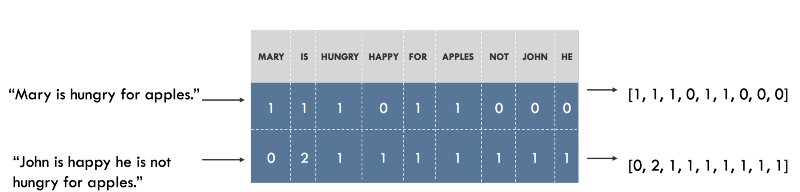

[Источник картинки](https://habr.com/ru/companies/oleg-bunin/articles/352614/)

In [ ]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

ngram_range отвечает за то, какие n-граммы мы используем в качестве признаков:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит отображение слов к их индексам:

In [ ]:
list(vec.vocabulary_.items())[:10]

[('включила', 112998),
 ('грустную', 122280),
 ('музыку', 160907),
 ('настроения', 164651),
 ('нет', 167738),
 ('пусть', 198694),
 ('на', 161842),
 ('улице', 227094),
 ('снег', 212104),
 ('душе', 129182)]

In [ ]:
list(vec.vocabulary_.items())[-10:]

[('tyteas_laal', 85713),
 ('нейтральная', 166502),
 ('warmer', 91217),
 ('darsergeevna', 23562),
 ('чырвонымі', 238002),
 ('шчакамі', 239931),
 ('бадзерая', 103040),
 ('сцвярджае', 218557),
 ('праверым', 191927),
 ('абароне', 97819)]

In [ ]:
len(vec.vocabulary_.items())

243745

Для оптимизации памяти матрица мешка слов хранится в формате csr_matrix. это класс в библиотеке SciPy, который представляет собой разреженную матрицу в формате Compressed Sparse Row (CSR). В этом типе данных сохраняются только ненулевые элеменгты матрицы в формате: (строка, столбец) значение.

In [ ]:
type(bow)

scipy.sparse._csr.csr_matrix

Рассмотрим строку полученной матрицф мешка слов:

In [ ]:
row = bow[10, :]
print(row)

  (0, 219815)	1
  (0, 74658)	1
  (0, 84185)	1
  (0, 67828)	1
  (0, 102151)	1
  (0, 111646)	1
  (0, 146154)	1
  (0, 204289)	1
  (0, 222096)	1
  (0, 241059)	1
  (0, 226547)	1


In [ ]:
row.shape

(1, 243745)

### Обучение модели:

In [ ]:
clf = LogisticRegression(random_state=42, max_iter=10000)
clf.fit(bow, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [ ]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.77      0.76     28183
    positive       0.77      0.76      0.77     28526

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



Попробуем сделать то же самое для триграмм:

In [ ]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.47      0.72      0.57     18233
    positive       0.82      0.61      0.70     38476

    accuracy                           0.64     56709
   macro avg       0.64      0.67      0.63     56709
weighted avg       0.71      0.64      0.66     56709



(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

## TF-IDF векторизация

`TfidfVectorizer` делает то же, что и `CountVectorizer`, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

TF (term frequency) – относительная частотность слова в документе:
$$ TF(t,d) = \frac{n_t}{\sum_k n_k} $$

`t` -- слово (term), `d` -- документ, $n_t$ -- количество вхождений слова, $n_k$ -- количество вхождений остальных слов

IDF (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ IDF(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

`t` -- слово (term), `D` -- коллекция документов

Перемножаем их:
$$TFIDF_(t,d,D) = TF(t,d) \times IDF(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом
количестве документов, у него высокий TF-IDF.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.73      0.78      0.75     26608
    positive       0.79      0.75      0.77     30101

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



## Токенизация

Токенизировать -- значит, поделить текст на слова, или *токены*.

Самый наивный способ токенизировать текст -- разделить с помощью `split`. Но `split` упускает очень много всего, например, банально не отделяет пунктуацию от слов. Кроме этого, есть ещё много менее тривиальных проблем. Поэтому лучше использовать готовые токенизаторы.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
example = 'Но не каждый хочет что-то исправлять:('
word_tokenize(example)

['Но', 'не', 'каждый', 'хочет', 'что-то', 'исправлять', ':', '(']

В nltk вообще есть довольно много токенизаторов:

In [ ]:
from nltk import tokenize

dir(tokenize)[:16]

['BlanklineTokenizer',
 'LegalitySyllableTokenizer',
 'LineTokenizer',
 'MWETokenizer',
 'NLTKWordTokenizer',
 'PunktSentenceTokenizer',
 'PunktTokenizer',
 'RegexpTokenizer',
 'ReppTokenizer',
 'SExprTokenizer',
 'SpaceTokenizer',
 'StanfordSegmenter',
 'SyllableTokenizer',
 'TabTokenizer',
 'TextTilingTokenizer',
 'ToktokTokenizer']

Они умеют выдавать индексы начала и конца каждого токена:

In [ ]:
wh_tok = tokenize.WhitespaceTokenizer()
list(wh_tok.span_tokenize(example))

[(0, 2), (3, 5), (6, 12), (13, 18), (19, 25), (26, 38)]

(если вам было интересно, зачем вообще включать в модуль токенизатор, который работает как `.split()` :))

Некторые токенизаторы ведут себя специфично:

In [ ]:
tokenize.TreebankWordTokenizer().tokenize("don't stop me")

['do', "n't", 'stop', 'me']

Для некоторых задач это может быть полезно.

А некоторые -- вообще не для текста на естественном языке (не очень понятно, зачем это в nltk :)):

In [ ]:
tokenize.SExprTokenizer().tokenize("(a (b c)) d e (f)")

['(a (b c))', 'd', 'e', '(f)']

Самым быстрым токенизатором является TokTokTokenizer, оцените, на сколько он быстрее обработает обучающие данные по сравнению со стандартным TreebankWordTokenizer:

In [ ]:
import time

start = time.time();
[tokenize.ToktokTokenizer().tokenize(tweet) for tweet in x_train]
end = time.time() - start
print(end)

12.68336033821106


In [ ]:
import time

start = time.time();
tokenized_x_train = [tokenize.TreebankWordTokenizer().tokenize(tweet) for tweet in x_train]
end = time.time() - start
print(end)

18.345330715179443


ToktokTokenizer почти в 2 раза быстрее!

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [ ]:
from nltk.corpus import stopwords

nltk.download('stopwords')
print(stopwords.words('russian'))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from string import punctuation


punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [ ]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.80      0.77      0.78     29311
    positive       0.76      0.79      0.78     27398

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



In [ ]:
len(vec.vocabulary_.items())

259704

Получилось чууть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть три хороших лемматизатора: mystem, pymorphy и natasha. Мы рассмотрим 2 наиболее современных: pymorphy и natasha.

### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [ ]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 59.2 MB/s eta 0:00:00


In [ ]:
!pip install pymorphy3-dicts-ru

In [ ]:
from pymorphy3 import MorphAnalyzer
pymorphy3_analyzer = MorphAnalyzer()

pymorphy3 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [ ]:
sent

['я', 'знаю', 'точно', 'невозможное', 'возможно']

In [ ]:
ana = pymorphy3_analyzer.parse(sent[3])
ana

[Parse(word='невозможное', tag=OpencorporaTag('ADJF,Qual neut,sing,nomn'), normal_form='невозможный', score=0.5, methods_stack=((DictionaryAnalyzer(), 'невозможное', 12, 14),)),
 Parse(word='невозможное', tag=OpencorporaTag('ADJF,Qual neut,sing,accs'), normal_form='невозможный', score=0.5, methods_stack=((DictionaryAnalyzer(), 'невозможное', 12, 17),))]

In [ ]:
ana[0].normal_form

'невозможный'

А теперь напишем функцию для лемматизации с pymorphy2:

In [ ]:
import re

punct = '[{}]'.format(punctuation)

def my_preproc(text):
    text = re.sub(punct, ' ', text)
    text = text.split()
    return [pymorphy3_analyzer.parse(word)[0].normal_form for word in text]

In [ ]:
example = 'Но не каждый хочет что-то исправлять:('

my_preproc(example)

['но', 'не', 'каждый', 'хотеть', 'что', 'то', 'исправлять']

In [ ]:
ru_stop_words = stopwords.words('russian') + [' ', '\n']

Что будет, если использовать её в качестве препроцессора?

In [ ]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc, stop_words=ru_stop_words)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['большой', 'весь', 'всё', 'ещё', 'мочь', 'нибыть', 'свой', 'хороший', 'это'] not in stop_words.
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.79      0.76      0.77     29317
    positive       0.75      0.78      0.77     27392

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



In [ ]:
len(list(vec.vocabulary_.items()))

177919

### [Natasha](https://github.com/natasha/)

В библиотеке natasha реализовано множество полезных библиотек для русского языка: разбиение на токены и предложения, русскоязычные word embeddings, морфологический, синтаксический анализ, лемматизация, извлечение именованных сущностей и т.д. Модуль библиотеки Razdel, основанный на правилах, предназначен для разбиения текста на токены и предложения.

In [ ]:
!pip install razdel

In [ ]:
from razdel import tokenize

tokens = list(tokenize('Кружка-термос на 0.5л (50/64 см³, 516;...)'))
tokens

[Substring(0, 13, 'Кружка-термос'),
 Substring(14, 16, 'на'),
 Substring(17, 20, '0.5'),
 Substring(20, 21, 'л'),
 Substring(22, 23, '('),
 Substring(23, 28, '50/64'),
 Substring(29, 32, 'см³'),
 Substring(32, 33, ','),
 Substring(34, 37, '516'),
 Substring(37, 38, ';'),
 Substring(38, 41, '...'),
 Substring(41, 42, ')')]

In [ ]:
[_.text for _ in tokens]

['Кружка-термос',
 'на',
 '0.5',
 'л',
 '(',
 '50/64',
 'см³',
 ',',
 '516',
 ';',
 '...',
 ')']

In [ ]:
!pip install natasha

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 79.5 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=260a4ccc3f9b5bdefcdbb70f9cdf44e3ca1071ddbc9bb4c13f4a2ee8c671dd8a
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=30527d769fd9d1949ffa3bd89d337522f93f05af58693d04a68df211581a5705
  Stored in directory: /root/.cache/pip/wheels/31/d7/d9/eec6891f78cac19a693bd40ecb8365d2f4613318c145ec9816
Successfully built docopt intervaltree


С помощью библиотеки natasaha можно также лемматизировать тексты.

In [ ]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  return {_.text: _.lemma for _ in doc.tokens}

In [ ]:
text = 'Банковская гарантия подтверждает обязательства банка по погашению долга клиента перед третьей стороной. Документ, по сути, является обеспечением контракта и позволяет совершить сделку без привлечения оборотных или заемных средств. Предоставление гарантии — это платная услуга. Клиент выплачивает банку определенную комиссию.'

natasha_lemmatize(text)

{'Банковская': 'банковский',
 'гарантия': 'гарантия',
 'подтверждает': 'подтверждать',
 'обязательства': 'обязательство',
 'банка': 'банк',
 'по': 'по',
 'погашению': 'погашение',
 'долга': 'долг',
 'клиента': 'клиент',
 'перед': 'перед',
 'третьей': 'третий',
 'стороной': 'сторона',
 '.': '.',
 'Документ': 'документ',
 ',': ',',
 'сути': 'суть',
 'является': 'являться',
 'обеспечением': 'обеспечение',
 'контракта': 'контракт',
 'и': 'и',
 'позволяет': 'позволять',
 'совершить': 'совершить',
 'сделку': 'сделка',
 'без': 'без',
 'привлечения': 'привлечение',
 'оборотных': 'оборотный',
 'или': 'или',
 'заемных': 'заемный',
 'средств': 'средство',
 'Предоставление': 'предоставление',
 'гарантии': 'гарантия',
 '—': '—',
 'это': 'это',
 'платная': 'платный',
 'услуга': 'услуга',
 'Клиент': 'клиент',
 'выплачивает': 'выплачивать',
 'банку': 'банк',
 'определенную': 'определенный',
 'комиссию': 'комиссия'}

### Снятие омонимии:

 *Снятие омонимии*. Natasha умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту:

In [ ]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'

In [ ]:
print(natasha_lemmatize(homonym1))
print(natasha_lemmatize(homonym2))

{'За': 'за', 'время': 'время', 'обучения': 'обучение', 'я': 'я', 'прослушал': 'прослушать', 'больше': 'большой', 'сорока': 'сорок', 'курсов': 'курс', '.': '.'}
{'Сорока': 'сорок', 'своровала': 'своровать', 'блестящее': 'блестящий', 'украшение': 'украшение', 'со': 'с', 'стола': 'стол', '.': '.'}


In [ ]:
print(my_preproc(homonym1))
print(my_preproc(homonym2))

['за', 'время', 'обучение', 'я', 'прослушать', 'большой', 'сорок', 'курс']
['сорок', 'своровать', 'блестящий', 'украшение', 'с', 'стол']


In [ ]:
homonym1 = 'В этом году лето жаркое.'
homonym2 = 'На обед подали жаркое в горшочках.'

In [ ]:
print(natasha_lemmatize(homonym1))
print(natasha_lemmatize(homonym2))

{'В': 'в', 'этом': 'этот', 'году': 'год', 'лето': 'лето', 'жаркое': 'жаркий', '.': '.'}
{'На': 'на', 'обед': 'обед', 'подали': 'подать', 'жаркое': 'жаркое', 'в': 'в', 'горшочках': 'горшочек', '.': '.'}


In [ ]:
print(my_preproc(homonym1))
print(my_preproc(homonym2))

['в', 'это', 'год', 'лето', 'жаркое']
['на', 'обед', 'подать', 'жаркое', 'в', 'горшочек']


## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [ ]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     28205
    positive       1.00      1.00      1.00     28504

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

In [ ]:
sorted_weights = clf.coef_.argsort()
sorted_weights = np.flip(sorted_weights)

vec.get_feature_names_out()[sorted_weights[:, 0:20]]

array([[')', 'd', 'dd', '^_^', '*', '-d', 'ddd', ':', 'dddd', 'ddddd',
        'люблю', 'ахах', 'ахахах', 'спасибо', 'мы', 'ахаха', 'х',
        'приятно', 'okirilyuk', 'dtoropova']], dtype=object)

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [ ]:
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.86      0.92     33099
    positive       0.83      1.00      0.91     23610

    accuracy                           0.92     56709
   macro avg       0.92      0.93      0.91     56709
weighted avg       0.93      0.92      0.92     56709



## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [ ]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.99      1.00      1.00     28216
    positive       1.00      0.99      1.00     28493

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1. Так или инчае, на символах классифицировать тоже можно: для некторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готвых анализаторов.